In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.Series(y).apply(lambda x: 10 if x == 0 else 1).values

# representations
print le.transform(['M', 'B'])

[1 0]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
lr = LogisticRegression()
lr.fit(X_train, y_train)
print lr.score(X_test, y_test)

0.956140350877


In [19]:
# Chain the Scaling, PCA and Logistic Regression
# together using a Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test accuracy: 0.947


In [4]:
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist: %s, Acc: %.3f' % (k+1,
                    np.bincount(y_train[train]), score))

print('CV accuracy: %.3f +/- %.3f' % (
        np.mean(scores), np.std(scores)))

Fold: 1, Class dist: [256 153], Acc: 0.891
Fold: 2, Class dist: [256 153], Acc: 0.978
Fold: 3, Class dist: [256 153], Acc: 0.978
Fold: 4, Class dist: [256 153], Acc: 0.913
Fold: 5, Class dist: [256 153], Acc: 0.935
Fold: 6, Class dist: [257 153], Acc: 0.978
Fold: 7, Class dist: [257 153], Acc: 0.933
Fold: 8, Class dist: [257 153], Acc: 0.956
Fold: 9, Class dist: [257 153], Acc: 0.978
Fold: 10, Class dist: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


In [5]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (
        np.mean(scores), np.std(scores))) 

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


In [7]:
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(
                        penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                          X=X_train,
                                          y=y_train,
                                          train_sizes=np.linspace(0.1, 1.0, 10),
                                          cv=10,
                                          n_jobs=3)

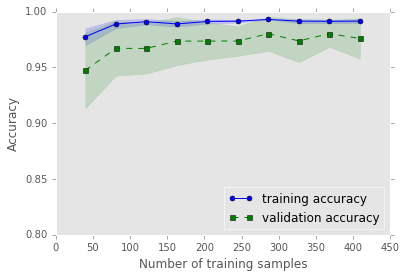

In [8]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

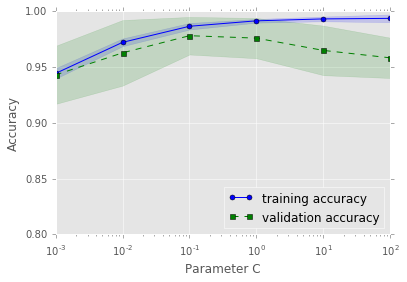

In [12]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                            estimator=pipe_lr,
                            X=X_train,
                            y=y_train,
                            param_name='clf__C',
                            param_range=param_range,
                            cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='training accuracy')
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 color='blue', alpha=0.15)
plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                color='green', alpha=0.15)
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
              'clf__kernel': ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [19]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [20]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid =param_grid,
                 scoring='accuracy',
                 cv=2,
                 n_jobs=1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy',
                        cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [24]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
               param_grid=[
                    {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                scoring='accuracy',
                cv=5)
scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=2)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.906 +/- 0.015


In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

print('Precision: %.3f' % precision_score(
                            y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(
                        y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
